In [1]:
import os
import openai
import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [2]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo


In [3]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

In [4]:
import panel as pn
import param
from IPython.display import display
import requests
from urllib.parse import urlparse
from pathlib import Path
from llama_index import download_loader
from pycld2 import pycld2
import icu

In [5]:
import load_documents

Image loading

In [6]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import cv2
from deskew import determine_skew
from skimage.transform import rotate, resize
from skimage import io as ioski

In [7]:
ImageReader = download_loader("ImageReader")

In [8]:
image = '../../Downloads/WhatsApp Image 2023-12-08 at 14.37.00_b3380c59.jpg'

In [9]:
#read image in gray scale format
read_img = cv2.imread(image, 0)

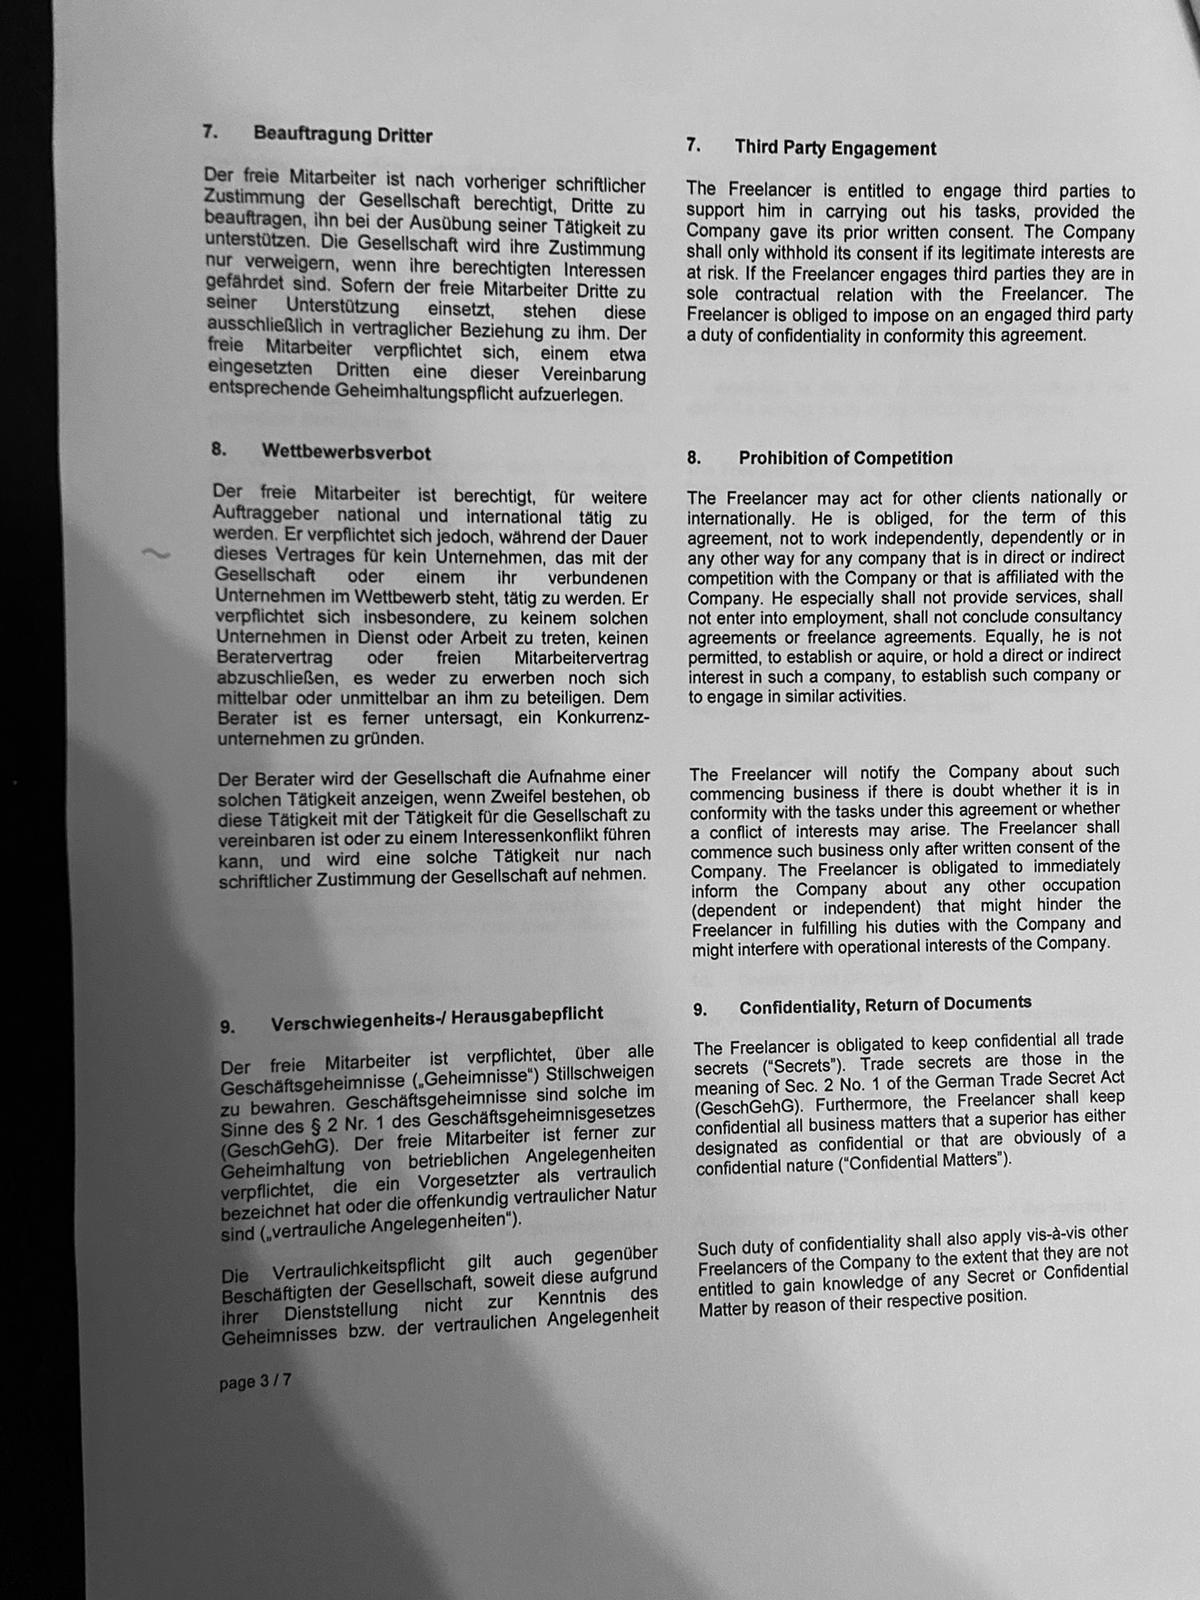

In [10]:
Image.fromarray(read_img)

In [11]:
dilated_img = cv2.dilate(read_img, np.ones((7,7), np.uint8)) 

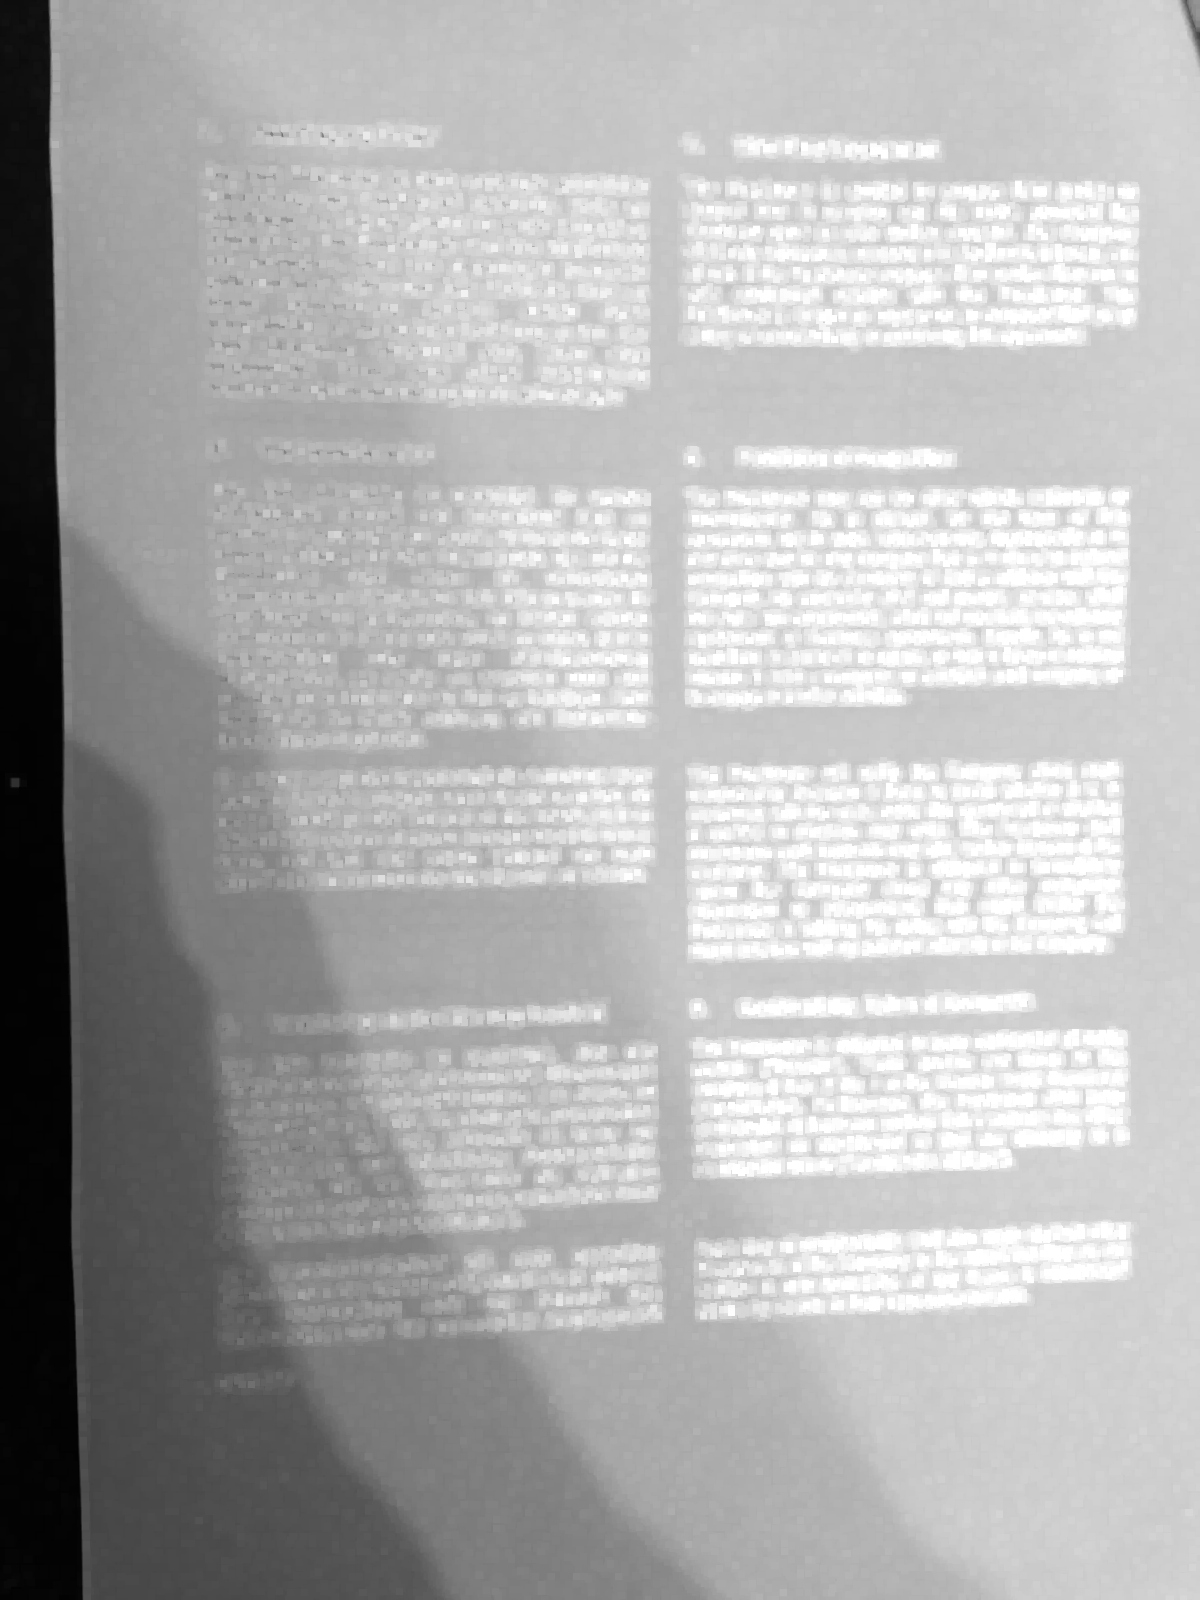

In [12]:
Image.fromarray(dilated_img)

In [13]:
bg_img = cv2.medianBlur(dilated_img, 21)

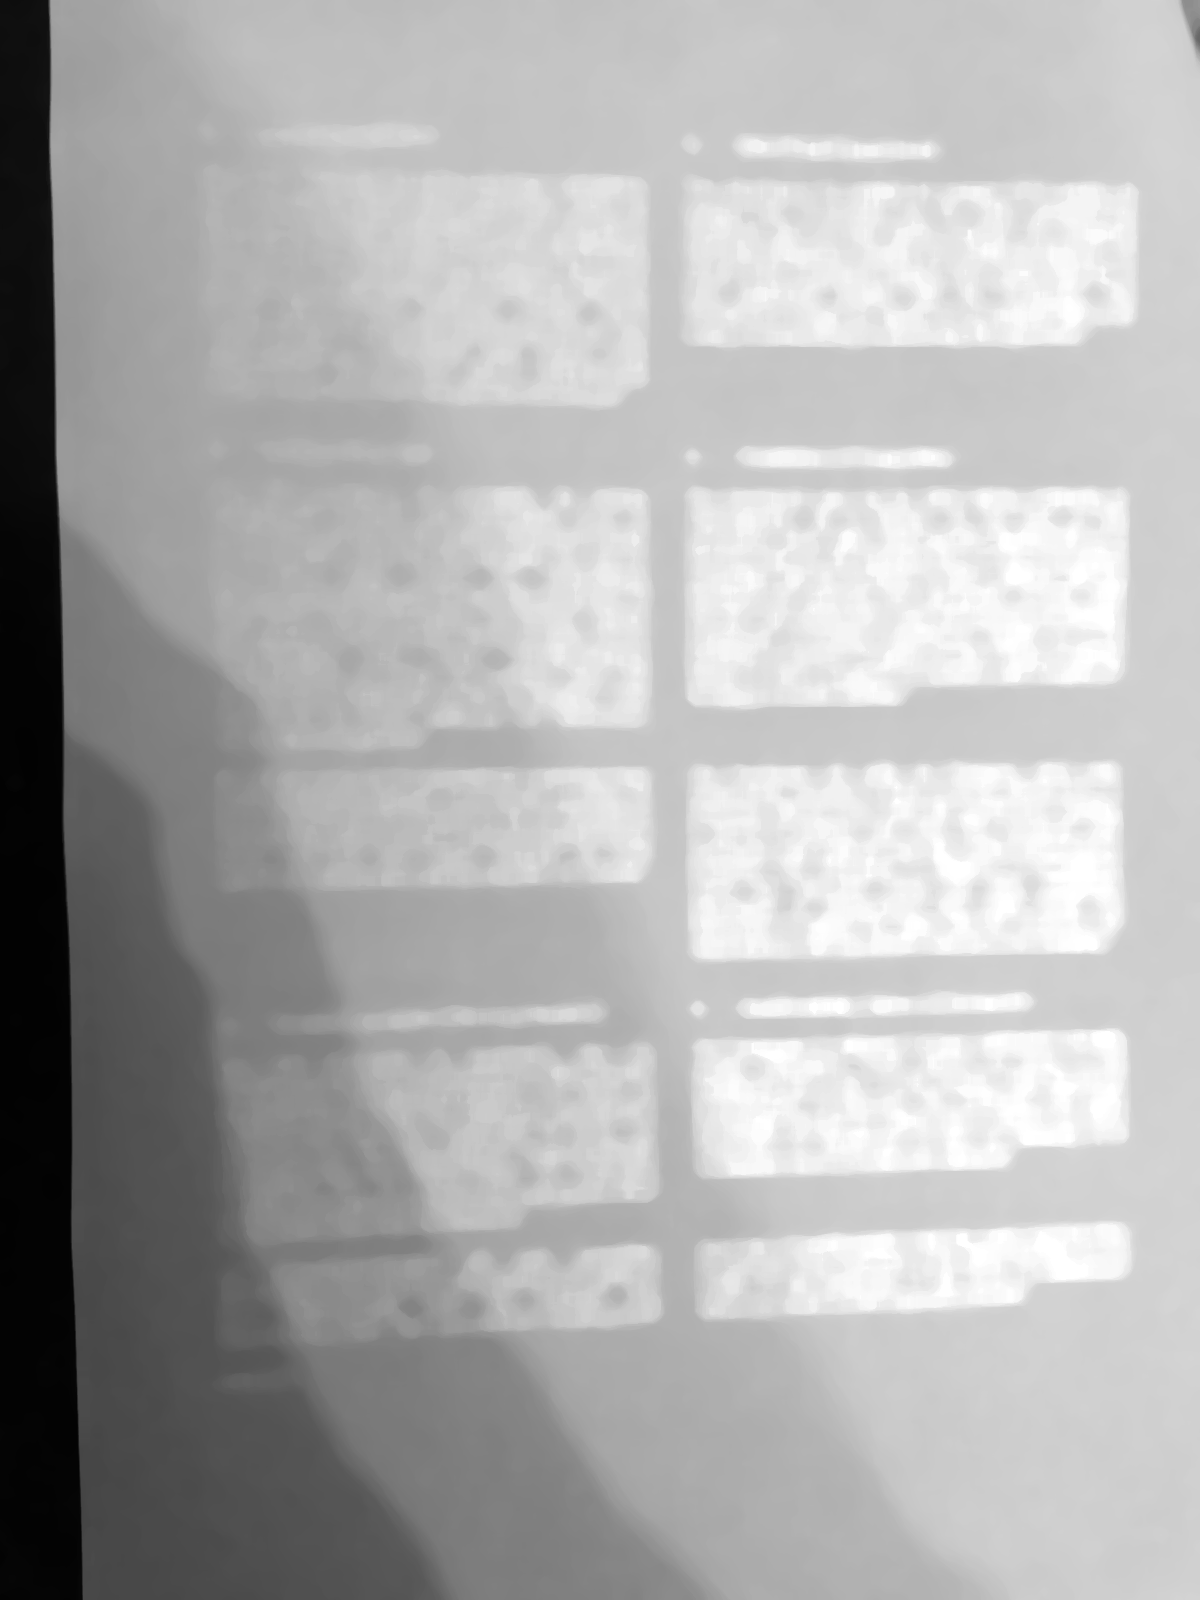

In [14]:
Image.fromarray(bg_img)

In [15]:
diff_img = 255 - cv2.absdiff(read_img, bg_img)

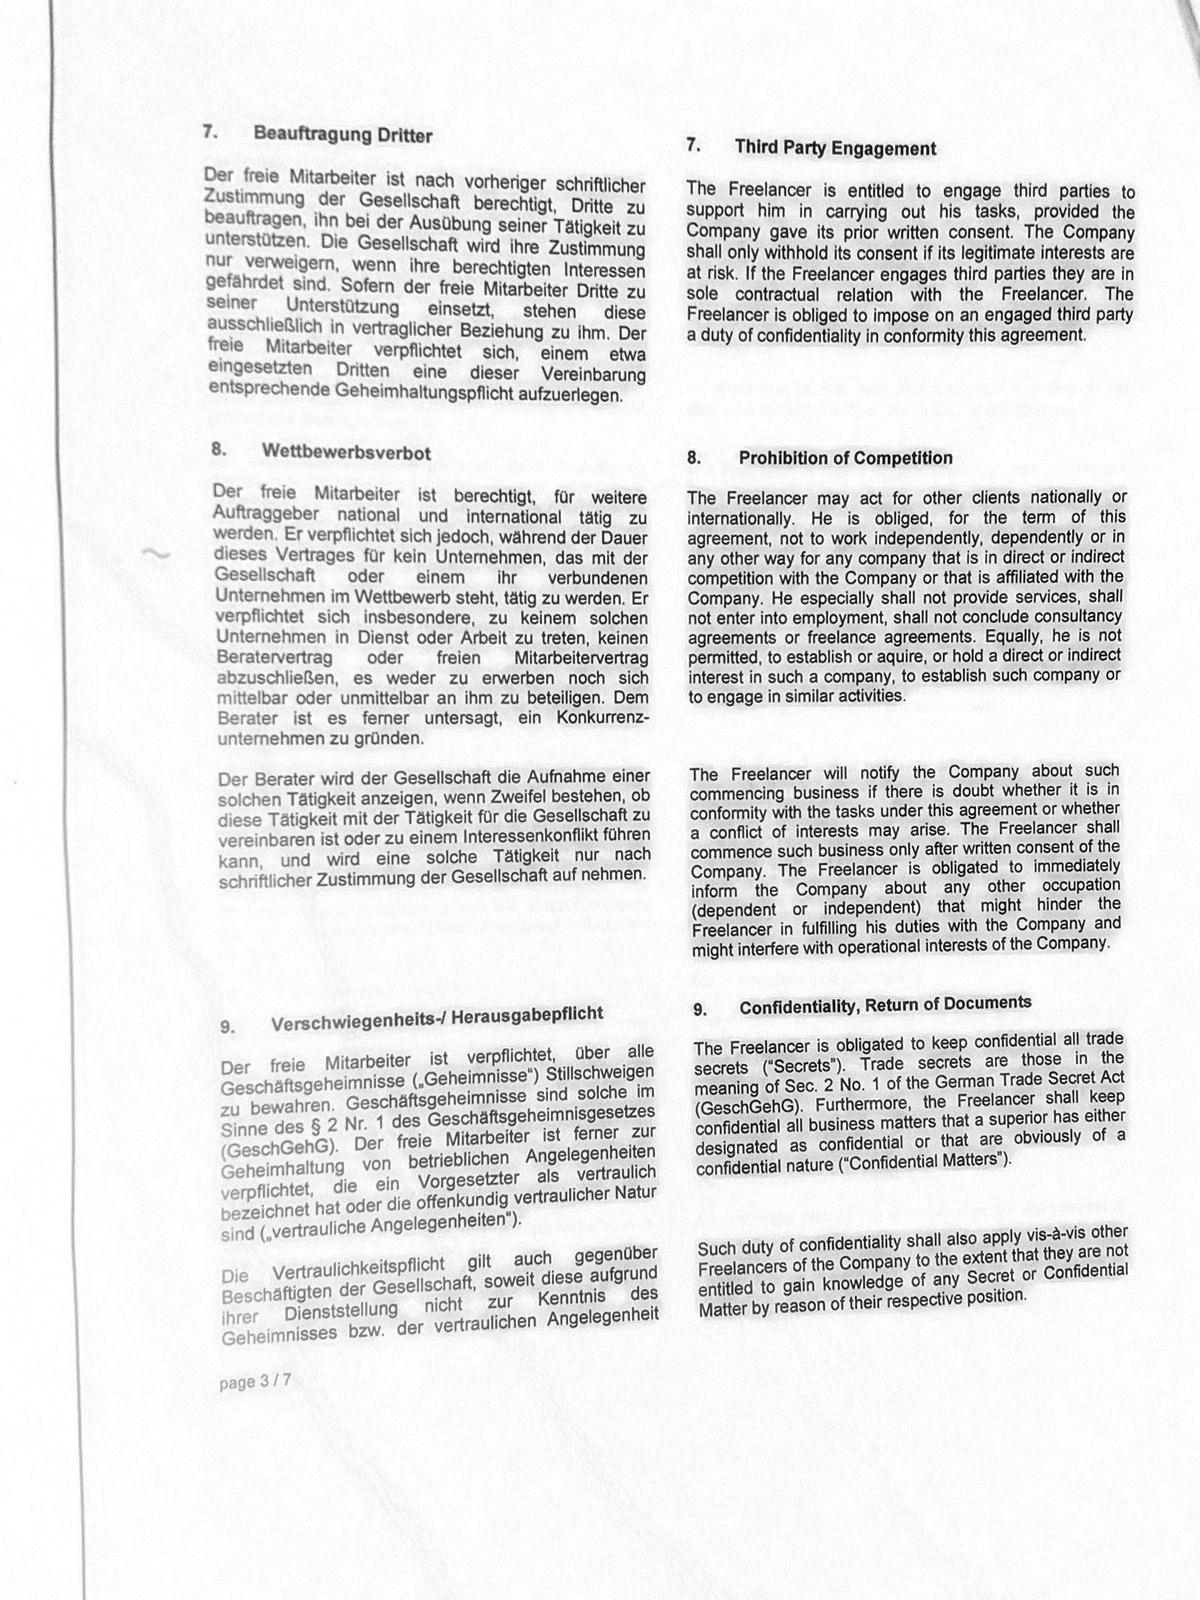

In [16]:
Image.fromarray(diff_img)

In [17]:
norm_img = diff_img.copy() # Needed for 3.x compatibility
cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

array([[255, 254, 253, ..., 252, 250, 244],
       [255, 254, 253, ..., 253, 248, 246],
       [255, 254, 253, ..., 247, 244, 246],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 254, 253, 252],
       [255, 255, 255, ..., 252, 251, 250]], dtype=uint8)

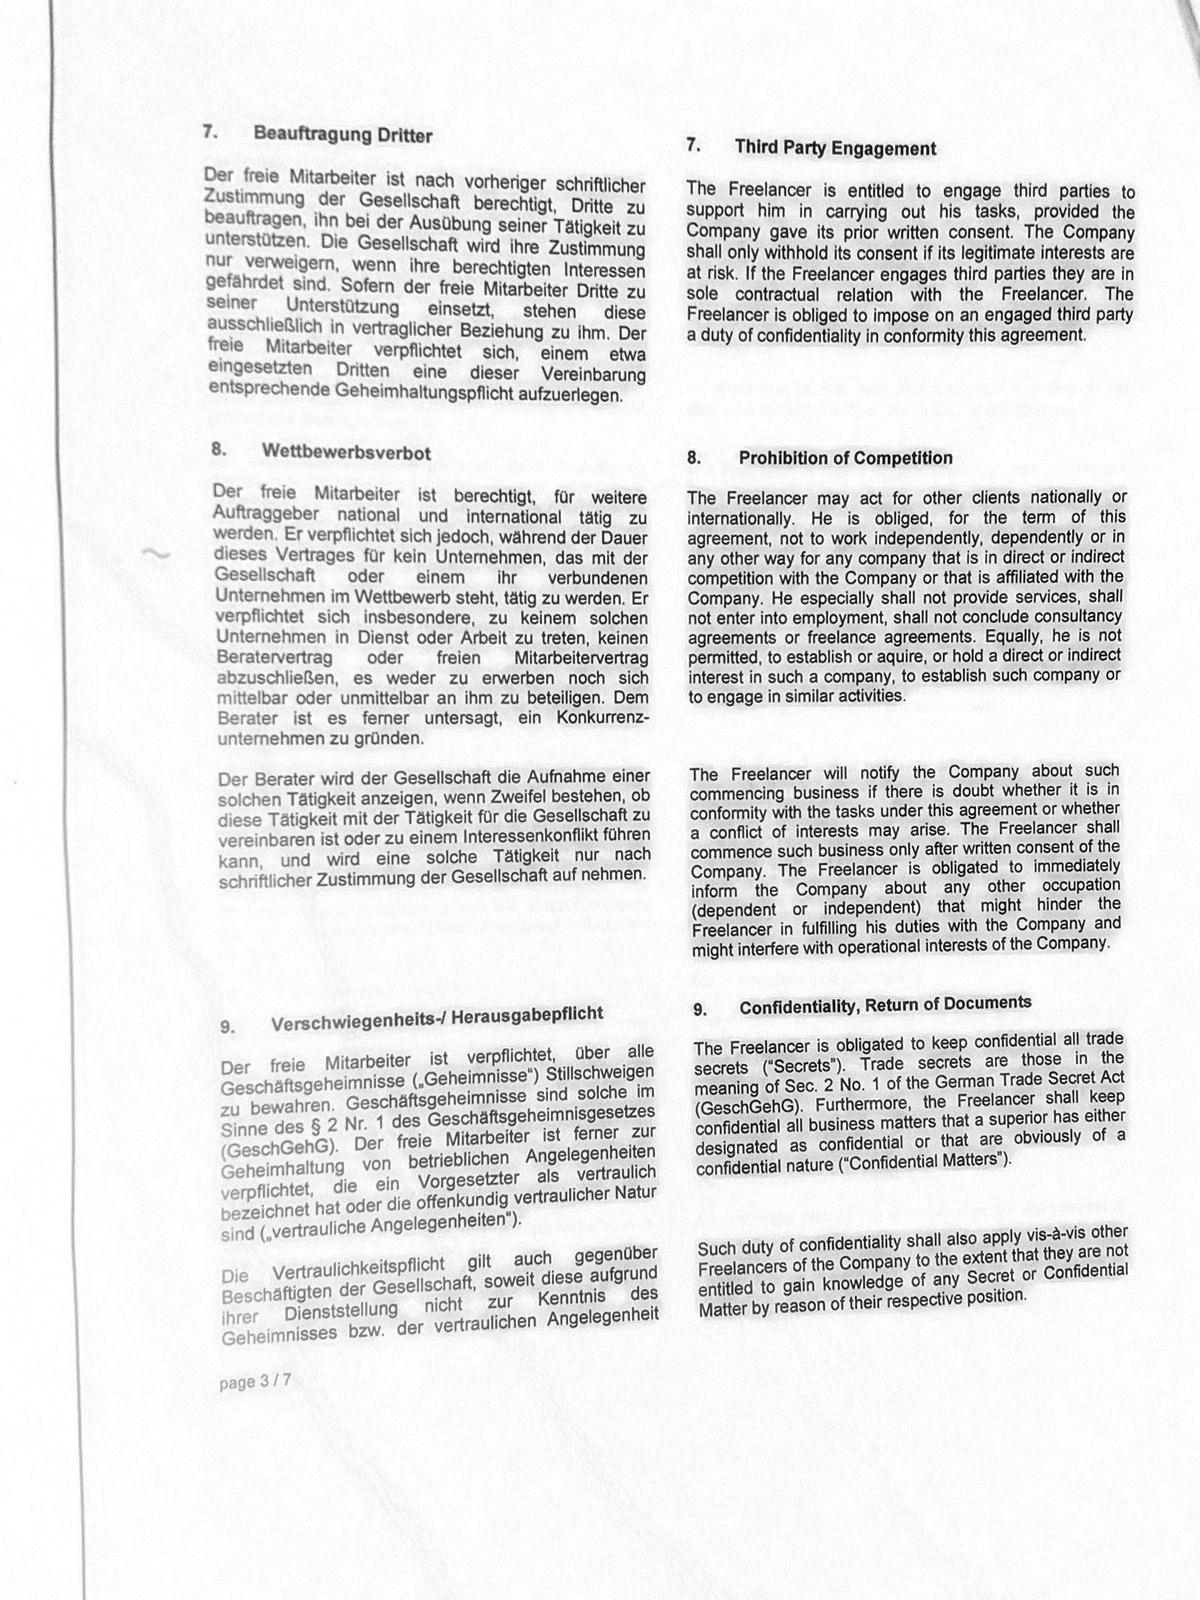

In [18]:
Image.fromarray(norm_img)

In [19]:
_, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

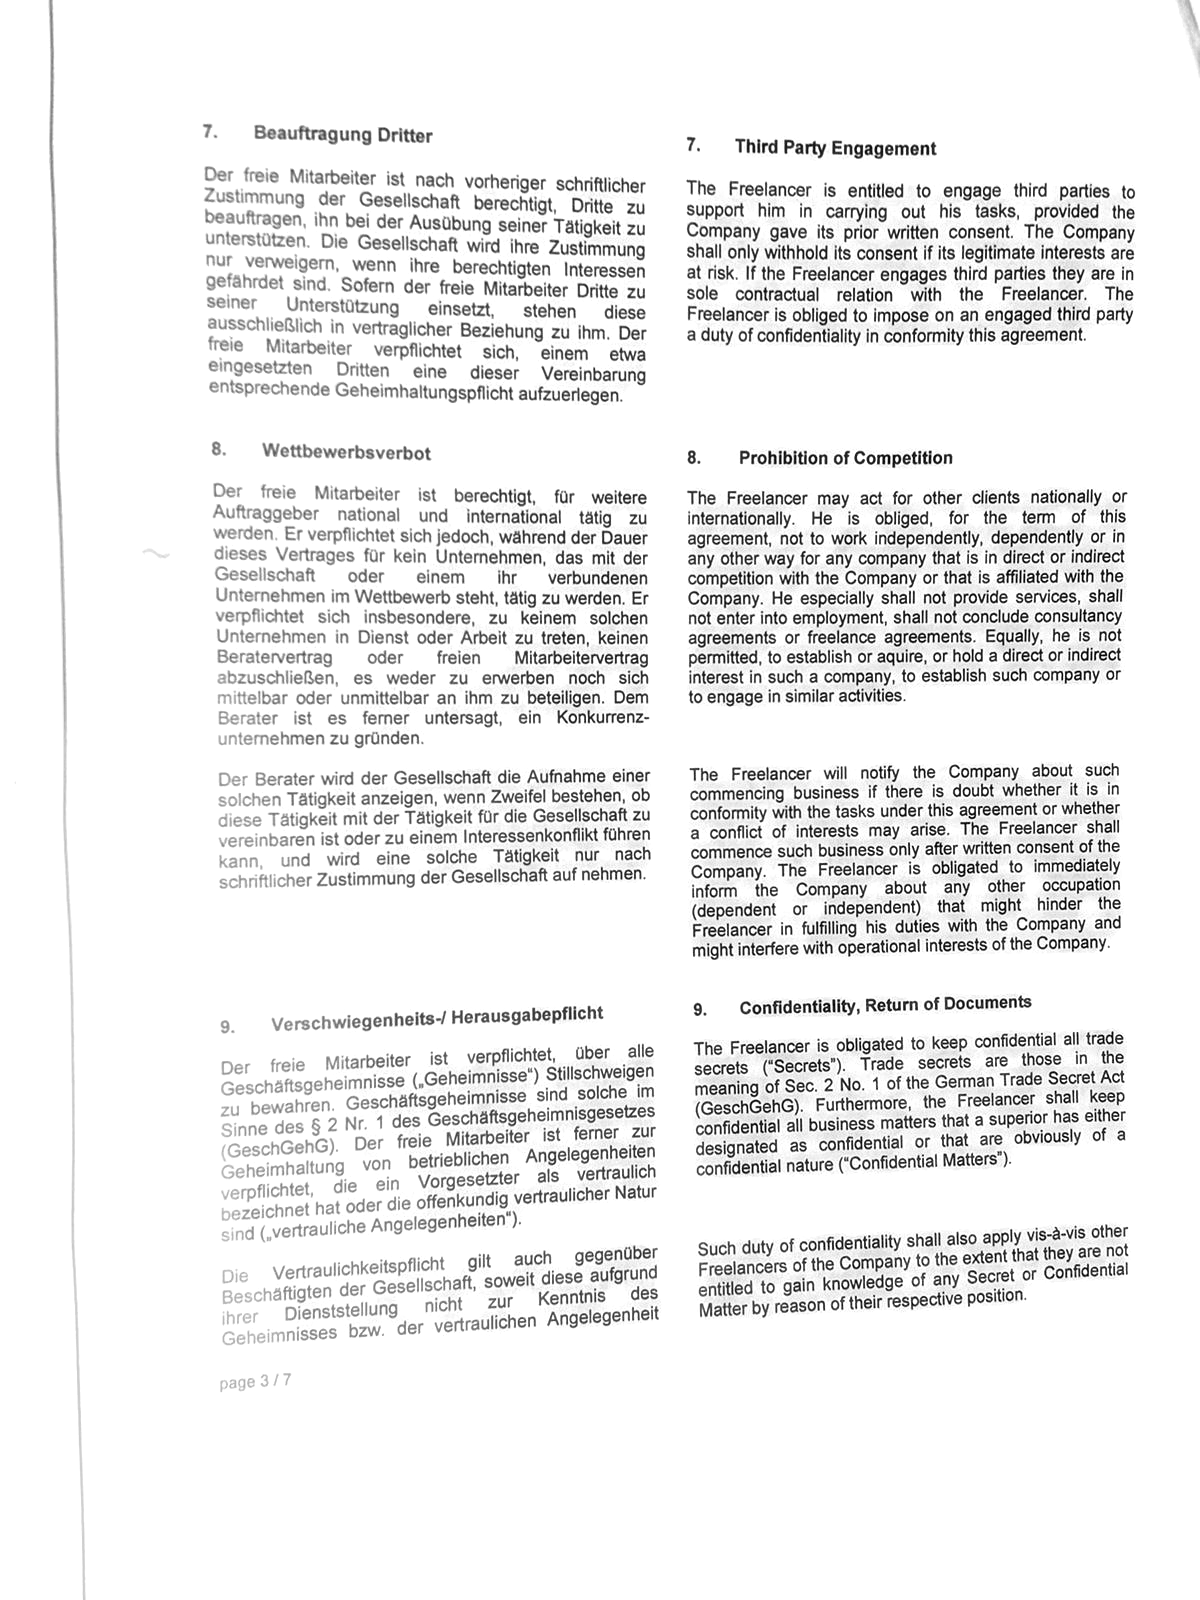

In [20]:
Image.fromarray(thr_img)

In [21]:
angle = determine_skew(thr_img)
print(angle)
#rotated_img = rotate(thr_img, angle)*255
#rotated_img = Image.fromarray(rotated_img.astype(np.uint8))

0.0


In [22]:
image_file = Image.fromarray(thr_img)

In [25]:
# Threshold
threshold = 222  # range from 0 to 255
image_file = image_file.point( lambda p: 255 if p > threshold else 0 )
image_file = image_file.convert('1')

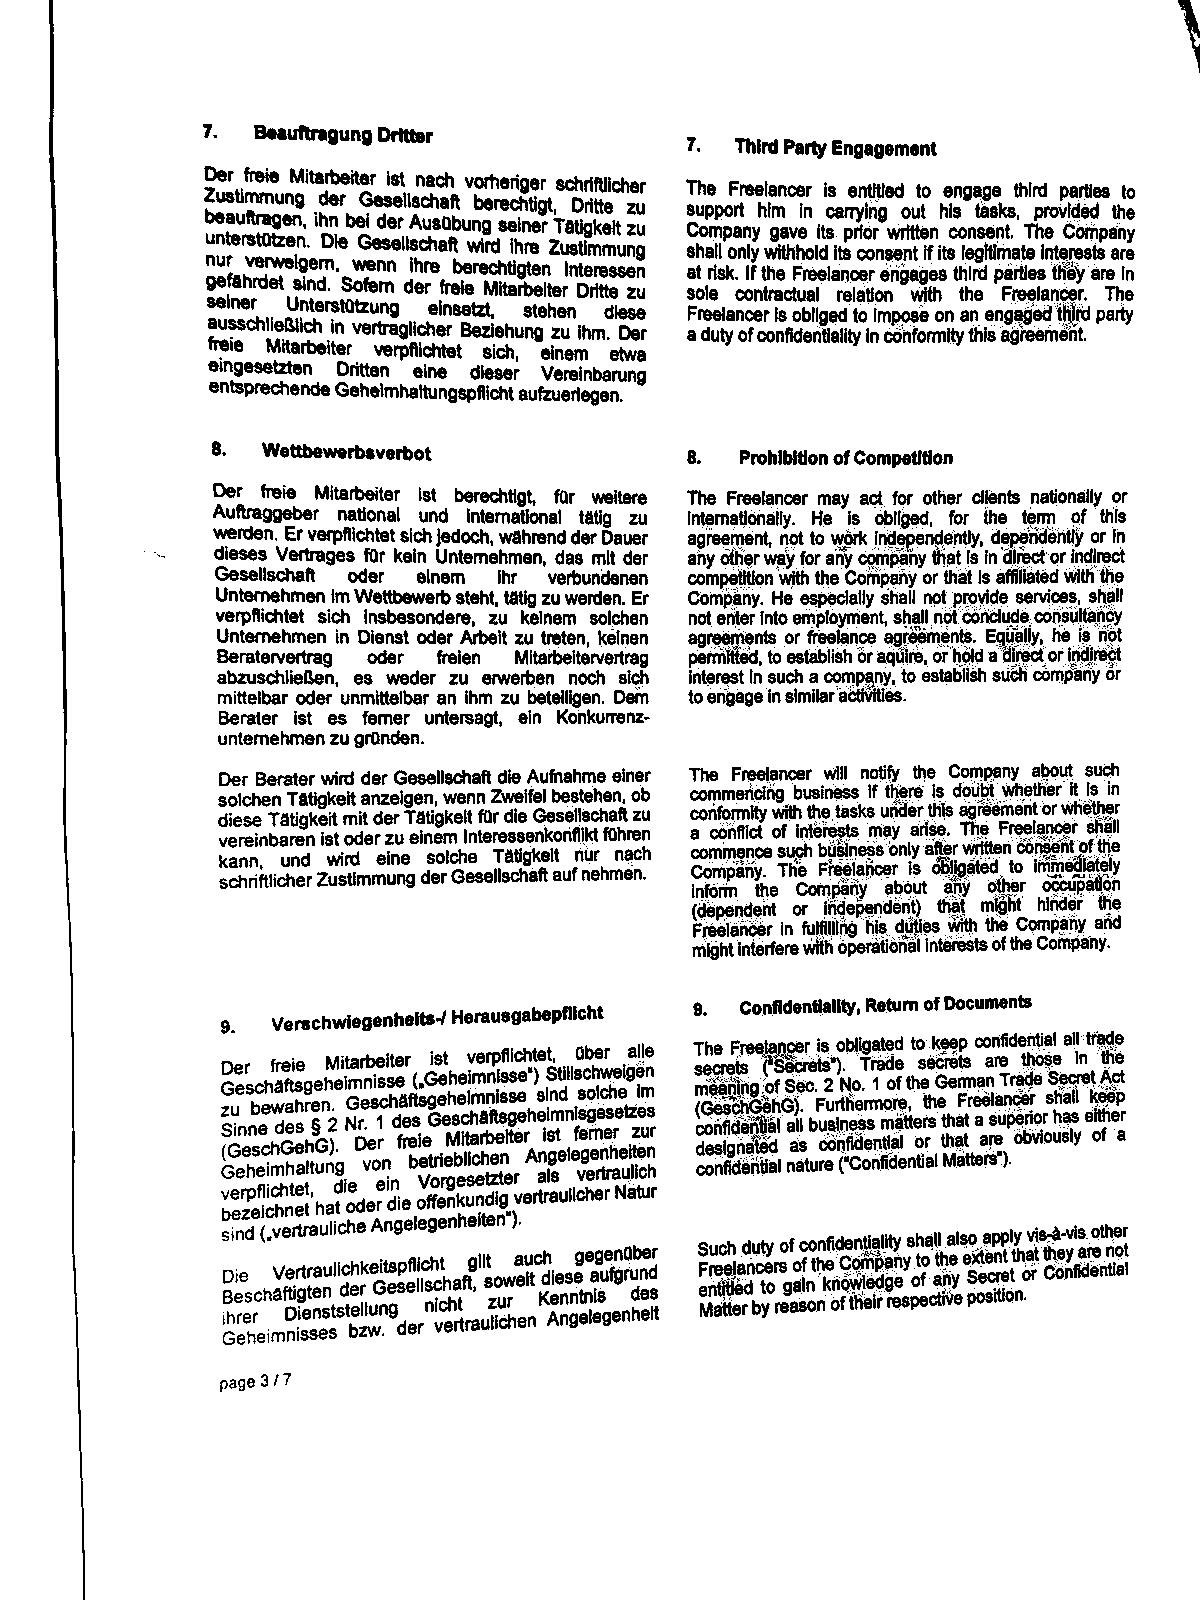

In [26]:
image_file

In [27]:
image_file.save('konv_slika.jpg')

In [28]:
conv_image_file = './konv_slika.jpg'

In [29]:
loader = ImageReader(text_type = "plain_text", model_kwargs=dict(lang="eng+ger"))
documents = loader.load_data(file=conv_image_file)
langchain_documents = [d.to_langchain_format() for d in documents]

In [30]:
print(langchain_documents[0].page_content)

7, Beauftragung Dritter

Der freie Mitarbeiter ist nach vorheriger
Zuatinmung. Ger Gesellschaft bore. ie,
benunragen, ihn bei der Ausdbung seiner ‘Tatigkelt zu
a rs in. Die Geselischaft wird ihre Zustimmung
fan eaern. wenn ihre berechtigten Interessen
gefahrdet sind. Sofem der frele Mitarbelter Dritta zu
seiner Unterstatzung einsatzt, stehen diese
ausschlieBiich in vertraglicher Beziehung zu ihm. Der
freie Mitarbeiter verpflichtat sich, sinem twa
eingesetzten Dritten eine dieser Vereinbarung
entsprechende Gehalmhattungspfiicht aufzuerlegen,

8. Wettbewerbsverbot

Der freie Mitarbeiter ist berechtl

igt, for weitere
Auftraggeber national und international tatig zu
werden, Er verpflichtet sich jedoch, wahrend der Dauer
dieses Vertrages fOr kein Untemehmen, das mit der
Geselischaft oder einem = ihr_—_-verbundsnen
Unternehmen im Wettbewerb steht, tatig zu werden. Er
verpfichtet sich insbesondere, zu kelnem solchen
Unternehmen in Dienst oder Arbeit zu treten, kelnen
Beratervertrag oder = fr

In [31]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US') 

pdf load

In [22]:
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
from langchain.document_loaders import UnstructuredFileLoader
import fitz
import pdfplumber

In [23]:
pdf_file = Path('../../Downloads/d.pdf')

In [24]:
with pdfplumber.open(pdf_file) as pdf:
        page = pdf.pages[0]
        text = page.extract_text()
        if text == '':
            print('ovde')

In [25]:
image_file_list = []

In [26]:
path_to_poppler_exe = Path(r"C:\Program Files\poppler-23.11.0\Library\bin")

In [27]:
pdf_pages = convert_from_path(
                pdf_file, 500, poppler_path=path_to_poppler_exe)

In [28]:
for page_enumeration, page in enumerate(pdf_pages, start=1):
        filename = f"page_{page_enumeration:03}.jpg"
        page.save(filename, "JPEG")
        image_file_list.append(filename)

In [29]:
output_file = "output_file.txt"

In [30]:
with open(output_file, "w", encoding="utf-8") as output_file:
    for image_file in image_file_list:
        loader = ImageReader(text_type = "plain_text", model_kwargs=dict(lang="eng"))
        document = loader.load_data(file=image_file)
        text = str(dict(document[0])['text'])
        output_file.write(text)

In [31]:
loader = UnstructuredFileLoader("output_file.txt")
docs = loader.load()

In [32]:
print(docs[0].page_content)

Placement Preparation Guide

This guide will cover everything you need to prepare for your dream job. The basic s- tructure of this course is as follows:

Resume Building

Application Procedure

Details about the interview rounds

Interview Experiences

Practice Tracks

Mock Tests

FAQs regarding placements

Additional Resources Placement preparation solely depends on the company for which you are preparing. There are basically three different categories into which we can divide the companies visiting campuses for placements based on their recruitment process.

1. Mass Recruiters

2. Tech Giants

3. Others / Start

ups

Companies belonging to the above categories have their own recruitment process. In this course, we will try to cover every possible detail required to know for cracking interview of the companies falling in each of the above categories. Resume Building According to the wiki definition,

A resume is a brief summary of your skills and experience over one or two pages.

A 

audio files

In [81]:
from langchain.schema.document import Document

In [65]:
import io
import os
import numpy as np

In [66]:
try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

In [67]:
import torch

In [68]:
import pandas as pd
import urllib
import tarfile
import whisper

In [69]:
import torchaudio

In [70]:
import torchvision

In [71]:
from scipy.io import wavfile

In [72]:
from tqdm.notebook import tqdm

In [73]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [74]:
DEVICE

'cuda'

In [75]:
print(torch.backends.cudnn.version())

8801


In [76]:
torch.cuda.is_available()

True

In [77]:
print(torch.__version__)

2.1.1+cu121


In [78]:
model = whisper.load_model('medium')

In [79]:
audio_file = './../../Downloads/Recording.m4a'

In [80]:
result = model.transcribe(audio_file)

In [84]:
docs = [Document(page_content=result['text'], metadata={"source": "local"})]

In [86]:
docs[0].page_content

" Und jetzt haben wir Nowak Djokovic. Hallo Nowak, mein Name ist Jessica. Ja, wie geht's? Guten Abend. Mir geht es gut, wie geht es dir? Sehr gut, ich freue mich hier zu sein heute Abend. Sehr viel. Ich bin begeistert von deinem Deutsch. Kannst du das von Boris? Ja, ich kenne auch Boris ein bisschen, aber ich habe in der Schule gelernt, und ich habe in Oberstein bei der Nicky-Pillich-Tennis-Akademie gelebt für 3 oder 4 Jahre. Ich habe viele Worte vergessen, aber es ist nicht so verspannt. Ich habe Spaß. Jetzt kommen alle Worte in meinen Kopf."

In [87]:
result = model.transcribe(audio_file, task='translate')

In [88]:
docs_tran = [Document(page_content=result['text'], metadata={"source": "local"})]

In [89]:
docs_tran[0].page_content

" Now we have Novak Djokovic. Hello Novak, my name is Jessica. How are you? Good evening. I'm fine, how are you? Very good, I'm happy to be here tonight. I'm excited about your German. Did you know that from Boris? Yes, I know a little bit from Boris, but I learned German in school. I lived in Obersteinheim at the Nicky Pile's Stennis Academy for 3 or 4 years. I forgot a lot of words, but it's not that tense. I would say so. I'm having fun. Now all the words come to my head."

presentations

In [6]:
from langchain.document_loaders import UnstructuredPowerPointLoader

In [7]:
ppt_file = './../../Downloads/01_OsnovniMetodiPretrazivanja.ppt'

In [8]:
loader = UnstructuredPowerPointLoader(ppt_file)

In [9]:
docs = loader.load()

In [10]:
print(docs[0].page_content)

Algoritmi i Strukture Podataka 2

1. Osnovni metodipretraživanja



Zadatak 1

Data je jednostruko ulančana lista sa zaglavljem. Skicirati algoritam sekvencijalnog pretraživanja liste za ključ k, ako se koristi graničnik. Koja je mana pristupa? Predložiti način(e) poboljšanja.

Rešenje: graničnik se dodaje na kraj liste. To je element liste ekvivalentan svim ostalim, koji sadrži ključ koji se traži (k).

	Lista se sekvencijalno pretražuje ali se vrši samo jedno testiranje – testiranje na vrednost ključa jer on sigurno postoji(nema potrebe testirati da li se došlo do kraja liste)

Elektrotehnički fakultet,

Beograd

Algoritmi i Strukture Podataka 2

<number>



Zadatak 1 - rešenje

LIST-SEQ-SEARCH-SENT(L, key)

addNode(L, key)

tekuci = L.first

while (tekuci.key  key) do

	tekuci = tekuci.next

end_while

if (tekuci = L.last) then

	tekuci = NIL

end_if

removeLastNode(L)

return tekuci 

Lista mora da se pretražujesekvencijalno.

Mana postupka: uklanjanje graničnog elementa liste 

In [95]:
filename = './../../Downloads/1.Uvod.pdf'

In [96]:
import tika
#tika.initVM()
from tika import parser
headers = { "X-Tika-OCRLanguage": "srp" }
parsed = parser.from_file(filename, requestOptions={'timeout': 300, 'headers': headers})
print(parsed["metadata"])
print(parsed["content"])

2023-12-07 17:15:43,680 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


{'pdf:PDFVersion': '1.5', 'pdf:docinfo:title': 'Истраживање података', 'xmp:CreatorTool': 'LaTeX with Beamer class', 'pdf:hasXFA': 'false', 'access_permission:can_print_degraded': 'true', 'X-TIKA:Parsed-By-Full-Set': ['org.apache.tika.parser.DefaultParser', 'org.apache.tika.parser.pdf.PDFParser', 'org.apache.tika.parser.ocr.TesseractOCRParser'], 'X-TIKA:content_handler': 'ToTextContentHandler', 'pdf:num3DAnnotations': '0', 'dc:format': 'application/pdf; version=1.5', 'pdf:docinfo:creator_tool': 'LaTeX with Beamer class', 'access_permission:fill_in_form': 'true', 'pdf:hasCollection': 'false', 'pdf:encrypted': 'false', 'dc:title': 'Истраживање података', 'pdf:containsNonEmbeddedFont': 'false', 'pdf:hasMarkedContent': 'false', 'pdf:docinfo:creator': 'Ненад Митић', 'PTEX.Fullbanner': 'This is MiKTeX-pdfTeX 4.14.0 (1.40.24)', 'access_permission:extract_for_accessibility': 'true', 'pdf:hasAcroFormFields': 'true', 'X-TIKA:Parsed-By': ['org.apache.tika.parser.DefaultParser', 'org.apache.tika.p

In [1]:
from langchain.document_loaders import JSONLoader

In [2]:
import json

In [11]:
import importlib  
foobar = importlib.import_module("neumai-tools")

ModuleNotFoundError: No module named 'neumai-tools'

In [10]:
from neumai-tools import jsonschema

SyntaxError: invalid syntax (1751542763.py, line 1)

In [6]:
json_file = './product_info.json'

In [7]:
loader = JSONLoader(file_path=json_file, jq_schema='.messages[].content')
docs = loader.load()

ImportError: jq package not found, please install it with `pip install jq`